# Modeling FQHC Total Health Center Funding Predictions

The goal of this notebook it to explore various regression models and their accuracy to predict the total health center funding a new entity could receive. 

During preprocessing, I saved 4 train/test splits based on:
1. whether RobustScaler() or PowerTransformer() was applied
2. whether missing data was imputed or removed

I will train and test Linear Regression models and Random Forest Regression models on the 4 data splits. I will also use PCA to reduce the number of components and add relevant components to the existing data (if this increases predictive capabilities)

All results will be scored with R2, Mean Squared Error, and Mean Absolute Error. I'll save cross-validation scoring results for the Linear Models. 

I plan to use GridSearch for the Random Forest Regressors to identify the best parameters. 

Cross-validation for all models will involve 5-fold splits. 

# Import Packages

In [1]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import plotly.express as px
from configuration.config import DATA_PATH, MODEL_DATA_PATH

In [3]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

## Tracking Scoring Metrics for Models

In [4]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
   
    global y_pred

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Metrics
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f'R2 Score: {r2_test}, Root Mean Squared Error: {rmse_test}, Mean Absolute Error: {mae_test}')
    
    y_pred = y_pred_test
   
    return rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test



In [5]:
model_scores = pd.DataFrame({
                             'model_type':[],
                             'train_test_split':[],
                             'is_pca':[], 
                             'score_rmse_train':[],
                             'score_rmse_test':[],
                             'score_mae_train':[],
                             'score_mae_test':[],
                             'score_r2_train':[],
                             'score_r2_test':[],
                             'cv_mean_r2':[],
                             'cv_std_r2':[],
                             'cv_mean_rmse':[],
                             'cv_std_rmse':[],
                             'cv_mean_mae':[],
                             'cv_std_mae':[],
                             'best_params':[] 
                            })
model_scores['is_pca'] = model_scores['is_pca'].astype(bool)
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params


In [6]:
def add_model_score(model_type, train_test_split, is_pca, score_rmse_train, score_rmse_test, score_mae_train, score_mae_test, score_r2_train, score_r2_test, cv_mean_r2, cv_std_r2, cv_mean_rmse, cv_std_rmse, cv_mean_mae, cv_std_mae, best_params=None):
    """
    Adds a row to the model_scores DataFrame with the specified model performance metrics.

    Parameters:
        model_scores (pd.DataFrame): DataFrame to log the results.
        model_type (str): Type of the model.
        train_test_split (str): Description of the data split used.
        is_pca (bool): Indicates if PCA was applied.
        score_rmse (float): Root Mean Squared Error of the model.
        score_mae (float): Mean Absolute Error of the model.
        score_r2 (float): R2 Score of the model.
        cross_val_mean (float): Mean of cross-validation scores.
        cross_val_std (float): Standard deviation of cross-validation scores.
        best_params (dict): Best parameters from model tuning.

    Returns:
        pd.DataFrame: Updated DataFrame with the new model scores.
    """
    global model_scores

    new_row_df = pd.DataFrame([{
        'model_type': model_type,
        'train_test_split': train_test_split,
        'is_pca': bool(is_pca),
        'score_rmse_train': score_rmse_train,
        'score_rmse_test': score_rmse_test,
        'score_mae_train': score_mae_train,
        'score_mae_test': score_mae_test,
        'score_r2_train': score_r2_train,
        'score_r2_test': score_r2_test,
        'cv_mean_r2': cv_mean_r2,
        'cv_std_r2': cv_std_r2,
        'cv_mean_rmse': cv_mean_rmse,
        'cv_std_rmse': cv_std_rmse,
        'cv_mean_mae': cv_mean_mae,
        'cv_std_mae': cv_std_mae,
        'best_params': best_params
    }])

    model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)

In [7]:
# import train/test splits for modeling the reduced and robust scaled data
X_train_rr = pd.read_csv(MODEL_DATA_PATH + 'X_train_reduced_robust.csv')
X_test_rr = pd.read_csv(MODEL_DATA_PATH + 'X_test_reduced_robust.csv')

# import train/test splits for modeling the reduced and power transformed data
X_train_rp = pd.read_csv(MODEL_DATA_PATH + 'X_train_reduced_power.csv')
X_test_rp = pd.read_csv(MODEL_DATA_PATH + 'X_test_reduced_power.csv')

# import train/test splits for modeling the imputed and robust scaled data
X_train_ir = pd.read_csv(MODEL_DATA_PATH + 'X_train_imputed_robust.csv')
X_test_ir = pd.read_csv(MODEL_DATA_PATH + 'X_test_imputed_robust.csv')

# import train/test splits for modeling the imputed and power transformed data
X_train_ip = pd.read_csv(MODEL_DATA_PATH + 'X_train_imputed_power.csv')
X_test_ip = pd.read_csv(MODEL_DATA_PATH + 'X_test_imputed_power.csv')

y_train = pd.read_csv(MODEL_DATA_PATH + 'y_train_data.csv').values.ravel()
y_test = pd.read_csv(MODEL_DATA_PATH + 'y_test_data.csv').values.ravel()

y_train_rounded = pd.read_csv(MODEL_DATA_PATH + 'y_train_rounded.csv').values.ravel()
y_test_rounded = pd.read_csv(MODEL_DATA_PATH + 'y_test_rounded.csv').values.ravel()

# Linear Models

## I. Reduced & Robust Scaled Data


In [8]:
print(X_train_rr.shape, y_train.shape, y_train_rounded.shape)
print(X_test_rr.shape, y_test.shape, y_test_rounded.shape)

(938, 54) (938,) (938,)
(402, 54) (402,) (402,)


### A. Linear Regression

In [9]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (-0.1010577329969589, 1.438583879600255),
 'neg_mean_squared_error': (-6901221651764.984, 8453882502242.107),
 'neg_mean_absolute_error': (-1163470.2550251505, 131911.47668259076)}

#### Model Training and Evaluation

R2 Score: 0.6356768347727072, Root Mean Squared Error: 1819935.3312204524, Mean Absolute Error: 1163949.5992701573


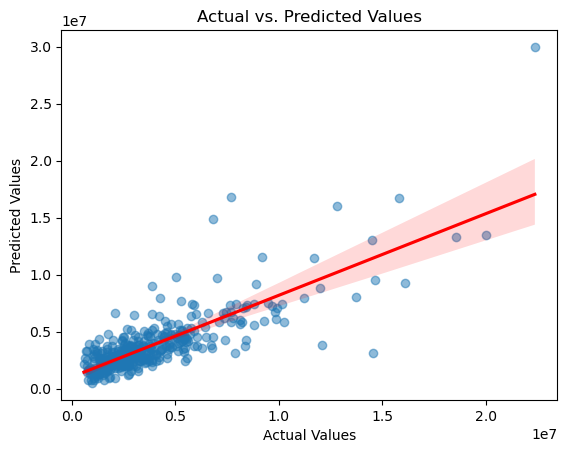

In [10]:
linear_model.fit(X_train_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust', bool(False), 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

In [11]:
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Linear Regression,reduced_robust,False,1.427076e+06,1.819935e+06,1.012823e+06,1.163950e+06,0.701817,0.635677,-0.101058,1.438584,-6.901222e+12,8.453883e+12,-1.163470e+06,131911.476683,None


### B. Linear Regression with PCA

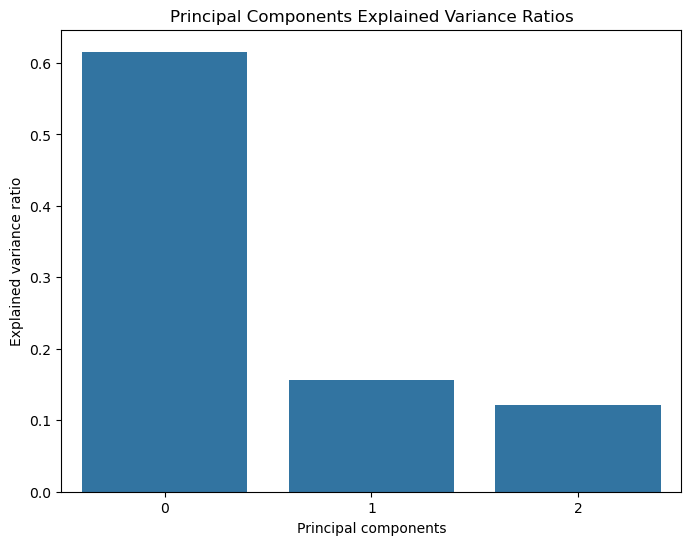

                             PC 1      PC 2      PC 3
public_insurance         0.960466 -0.003223 -0.003723
public_insurance_ratio   0.275962 -0.021438 -0.076193
migrant_patients         0.023620  0.006374  0.974945
public_housing_patients  0.012083  0.006872  0.008426
lep_patients             0.010084  0.026872  0.026635
hispanic_any_race        0.008783  0.035601  0.036899
homeless_patients        0.007382  0.013259  0.014845
total_other_revenue      0.007371  0.997612 -0.011548
medicaid                 0.006957  0.022602  0.019304
total_patients           0.006729  0.016829  0.017358
diverse_patients_sum     0.006483  0.004002  0.001975
school_based_patients    0.006089  0.004223  0.014896
low_income               0.005613  0.018900  0.018359
uninsured                0.005584  0.007602  0.016010
total_grant_funding      0.004918  0.016093  0.006007


In [12]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_rr)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rr)
X_test_pca = pca.transform(X_test_rr)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_rr.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [13]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_train_rr.index)
X_train_pca_rr = pd.concat([X_train_rr, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_test_rr.index)
X_test_pca_rr = pd.concat([X_test_rr, X_test_pca_df], axis=1)

R2 Score: 0.6396102678940887, Root Mean Squared Error: 1810084.1583620356, Mean Absolute Error: 1166834.2835820895


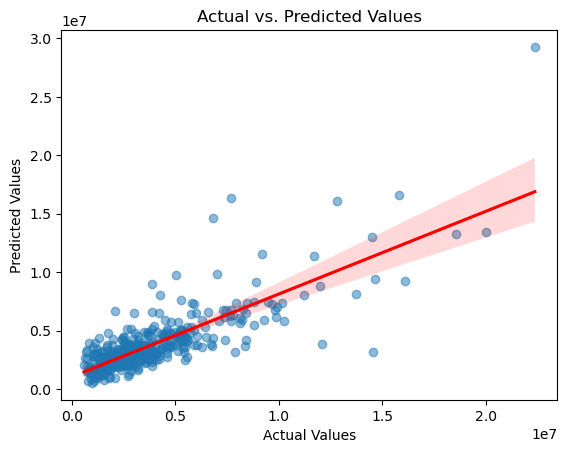

In [14]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

In [15]:
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Linear Regression,reduced_robust,False,1.427076e+06,1.819935e+06,1.012823e+06,1.163950e+06,0.701817,0.635677,-0.101058,1.438584,-6.901222e+12,8.453883e+12,-1.163470e+06,131911.476683,None
1,Linear Regression,reduced_robust,True,1.441341e+06,1.810084e+06,1.019353e+06,1.166834e+06,0.695826,0.639610,-0.101058,1.438584,-6.901222e+12,8.453883e+12,-1.163470e+06,131911.476683,None


### Rounded

R2 Score: 0.6356719061431604, Root Mean Squared Error: 1820661.6154209787, Mean Absolute Error: 1164966.7992064923


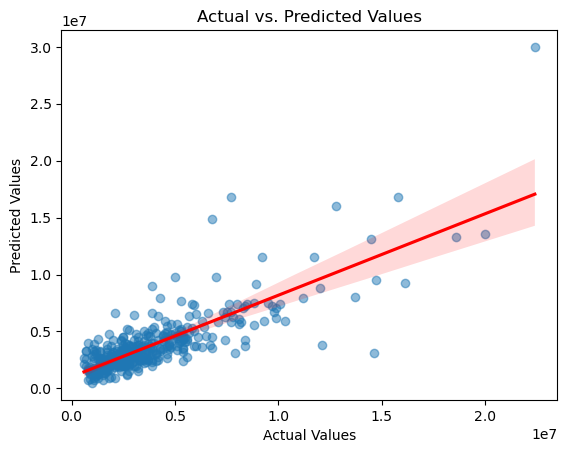

In [16]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_rr, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## II. Reduced & Power Transformed Data

### A. Linear Regression

In [17]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.6132553461864595, 0.03144365298639785),
 'neg_mean_squared_error': (-2602495430331.0317, 462229048846.88007),
 'neg_mean_absolute_error': (-1158111.5228426154, 83887.80224131916)}

R2 Score: 0.6119049479995747, Root Mean Squared Error: 1878372.0437015982, Mean Absolute Error: 1298101.7091721224


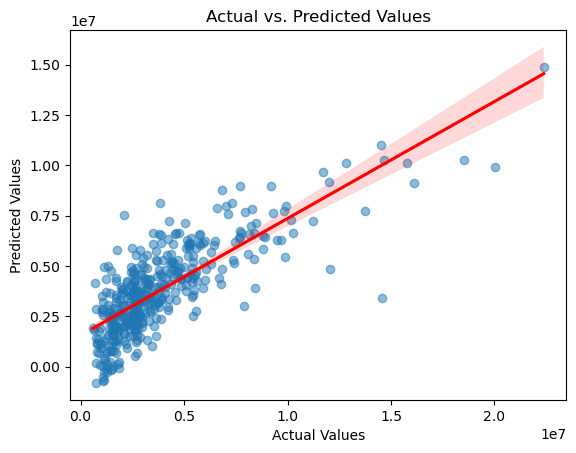

In [18]:
linear_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### B. Linear Regression with PCA

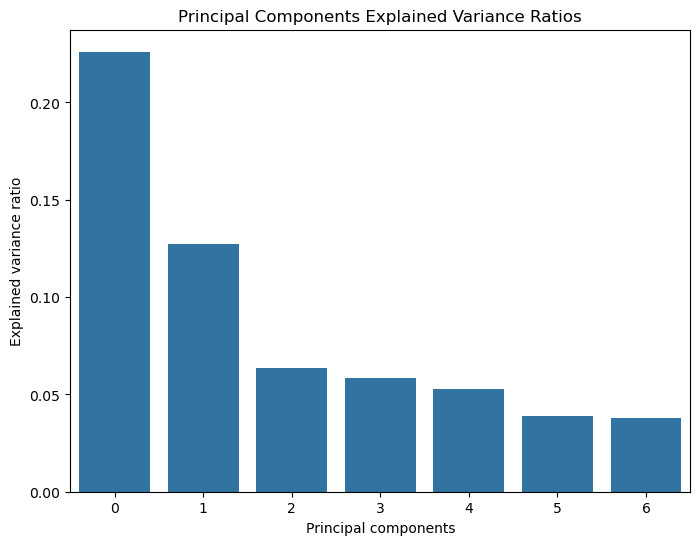

                                 PC 1      PC 2      PC 3      PC 4      PC 5  \
total_patients               0.263019  0.111760 -0.001462 -0.032649 -0.041719   
low_income                   0.256218 -0.006275  0.042861 -0.008991 -0.132455   
medicaid                     0.255695  0.066152  0.013286 -0.129270 -0.028822   
hispanic_any_race            0.247609 -0.071561 -0.123040  0.109504  0.033178   
lep_patients                 0.239464 -0.101373 -0.125002  0.073191  0.072291   
uninsured                    0.234799 -0.029566 -0.047092  0.118267 -0.039002   
total_grant_funding          0.232464  0.018241  0.022146  0.012411  0.019813   
TotalWeeklyHoursOfOperation  0.213965  0.125729  0.090484  0.002109 -0.158758   
ZipCode_Count                0.205842  0.041552  0.048586 -0.082069 -0.032902   
total_sites                  0.201709  0.121013  0.105515  0.004676 -0.179624   
diverse_patients_sum         0.193075 -0.042476  0.136368 -0.220656 -0.009110   
medicare_18_up              

In [19]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_rp)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rp)
X_test_pca = pca.transform(X_test_rp)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_rp.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [20]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_rp.index)
X_train_pca_rp = pd.concat([X_train_rp, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_rp.index)

X_test_pca_rp = pd.concat([X_test_rp, X_test_pca_df], axis=1)

R2 Score: 0.6136552077188329, Root Mean Squared Error: 1874131.646922348, Mean Absolute Error: 1294555.1629845223


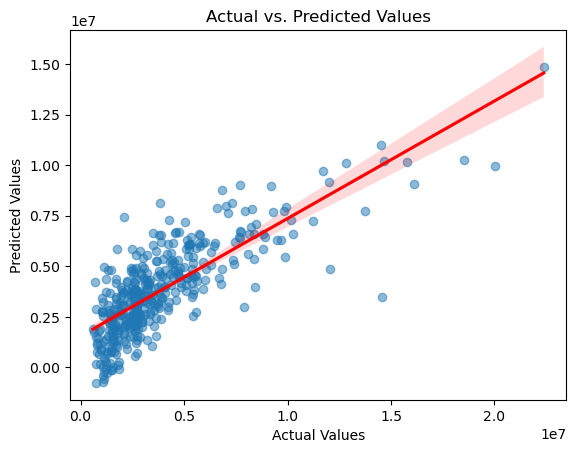

In [21]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rp, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

In [22]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores



{'r2': (0.6130161078497602, 0.03087326669095578),
 'neg_mean_squared_error': (-2603601881132.751, 469681284200.54),
 'neg_mean_absolute_error': (-1159706.0843612037, 85063.70254214092)}

R2 Score: 0.6119397896736288, Root Mean Squared Error: 1879024.5864424997, Mean Absolute Error: 1301315.113220077


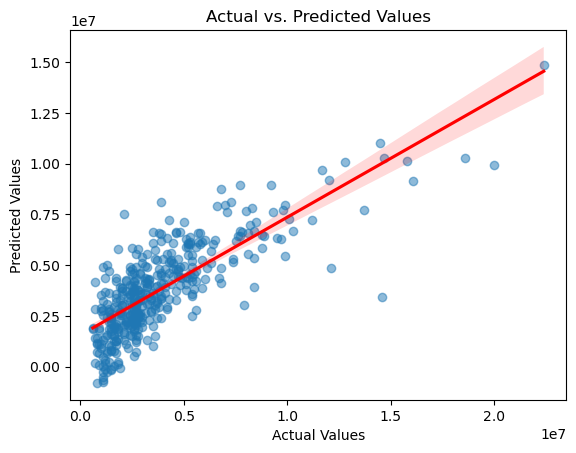

In [23]:
linear_model.fit(X_train_rp, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## III. Imputed & Robust Scaled Data

### A. Linear Regression

In [24]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.1547238125446347, 0.9438295434797247),
 'neg_mean_squared_error': (-5363971213007.419, 5512018199346.475),
 'neg_mean_absolute_error': (-1141935.0421730238, 123364.19004813602)}

R2 Score: 0.6218655804631834, Root Mean Squared Error: 1854110.7347193444, Mean Absolute Error: 1184594.2813578972


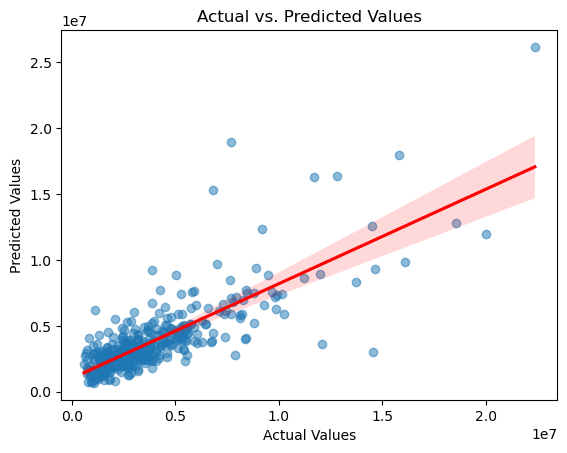

In [25]:
linear_model.fit(X_train_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Linear Regression PCA

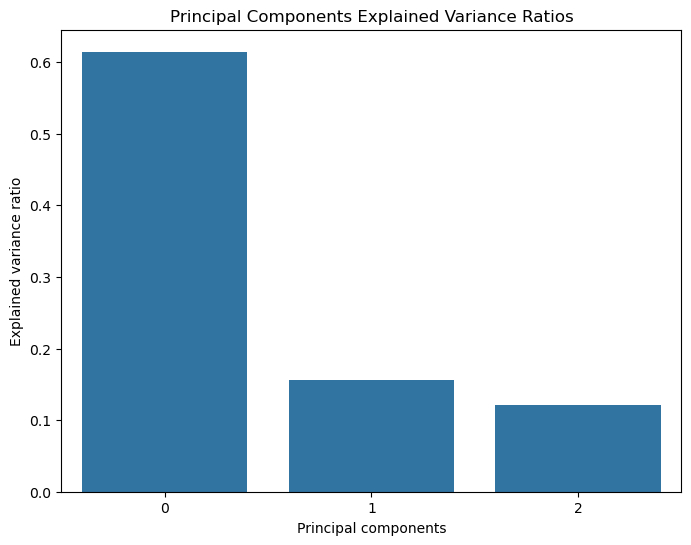

                             PC 1      PC 2      PC 3
public_insurance         0.960372 -0.003685 -0.004033
public_insurance_ratio   0.275892 -0.022165 -0.076837
migrant_patients         0.023710  0.009017  0.974451
public_housing_patients  0.012104  0.007051  0.008611
lep_patients             0.010103  0.027040  0.026665
hispanic_any_race        0.008805  0.035794  0.036894
total_sfs                0.007714  0.022009  0.014189
total_other_revenue      0.007509  0.997057 -0.015162
homeless_patients        0.007399  0.013406  0.014941
total_visits             0.007267  0.009665  0.013702
total_cost_care          0.007115  0.017783  0.012819
medicaid                 0.006973  0.022735  0.019335
total_patients           0.006744  0.016962  0.017411
diverse_patients_sum     0.006492  0.004077  0.002052
school_based_patients    0.006114  0.004458  0.015129


In [26]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_ir)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ir)
X_test_pca = pca.transform(X_test_ir)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_ir.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [27]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_train_ir.index)
X_train_pca_ir = pd.concat([X_train_ir, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_test_ir.index)
X_test_pca_ir = pd.concat([X_test_ir, X_test_pca_df], axis=1)


R2 Score: 0.6112733825861595, Root Mean Squared Error: 1879899.8041896392, Mean Absolute Error: 1202774.865671642


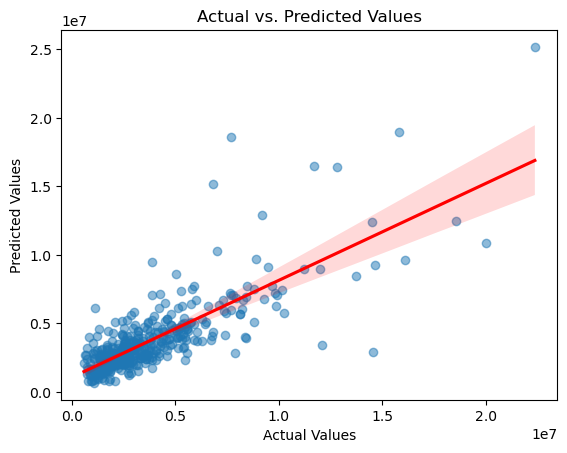

In [28]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ir, X_test_pca_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

R2 Score: 0.6216966365604665, Root Mean Squared Error: 1855252.4195806794, Mean Absolute Error: 1185493.052374157


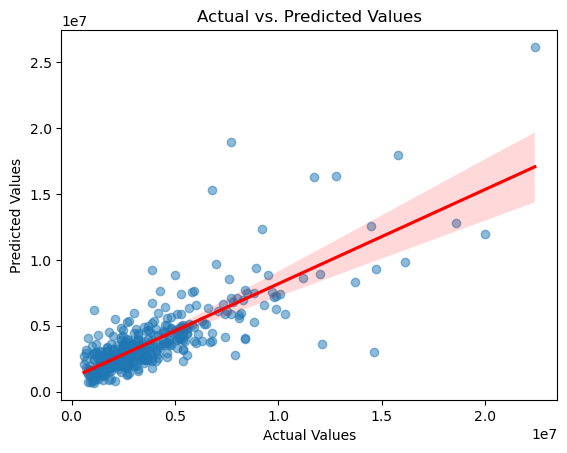

In [29]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ir, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## IV. Imputed & Power Transformed Data

### A. Linear Regression

In [30]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.6051520407794942, 0.03169908668529646),
 'neg_mean_squared_error': (-2649844974990.833, 422243577616.6385),
 'neg_mean_absolute_error': (-1163805.834642091, 79869.42038150752)}

R2 Score: 0.6150466544206603, Root Mean Squared Error: 1870753.697239361, Mean Absolute Error: 1291873.037959073


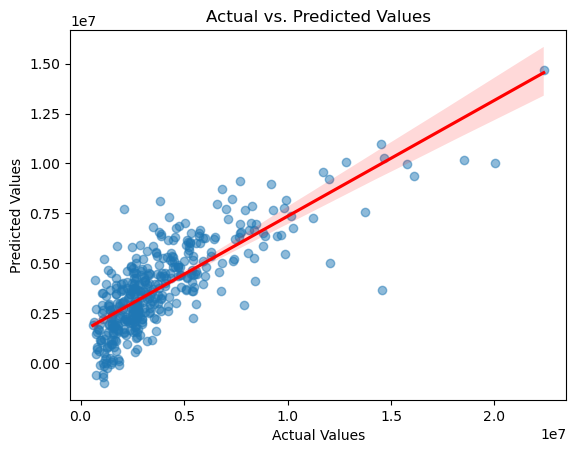

In [31]:
linear_model.fit(X_train_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Linear Regression PCA

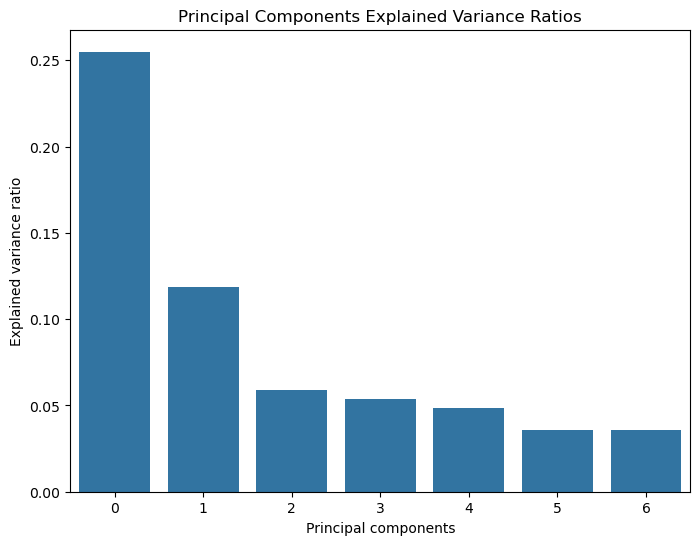

                                 PC 1      PC 2      PC 3      PC 4      PC 5  \
total_patients               0.241270  0.097821 -0.008886 -0.035401 -0.039083   
total_visits                 0.241204  0.087653  0.019096 -0.029643 -0.028591   
total_cost_care              0.237240  0.078190  0.039401 -0.024917  0.021523   
medicaid                     0.231757  0.054581  0.008956 -0.137488 -0.027323   
low_income                   0.230301 -0.019187  0.033828 -0.013043 -0.126025   
hispanic_any_race            0.220833 -0.084904 -0.128826  0.100107  0.038927   
total_grant_funding          0.213375  0.005973  0.021207  0.011531  0.020723   
uninsured                    0.212025 -0.044642 -0.058794  0.120813 -0.033853   
lep_patients                 0.211805 -0.113700 -0.130686  0.062638  0.076669   
total_sfs                    0.200990 -0.044959 -0.055611  0.076925 -0.010999   
TotalWeeklyHoursOfOperation  0.194491  0.112490  0.082184  0.003413 -0.152415   
ZipCode_Count               

In [32]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_ip)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ip)
X_test_pca = pca.transform(X_test_ip)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_ip.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [33]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_ip.index)
X_train_pca_ip = pd.concat([X_train_ip, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_ip.index)

X_test_pca_ip = pd.concat([X_test_ip, X_test_pca_df], axis=1)



R2 Score: 0.6161313006190456, Root Mean Squared Error: 1868116.3163324709, Mean Absolute Error: 1288004.051785646


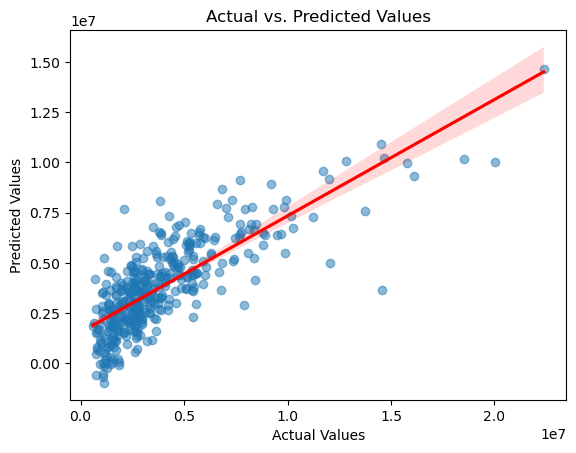

In [34]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ip, X_test_pca_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [35]:
add_model_score('Linear Regression', 'imputed_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

R2 Score: 0.6151213936290783, Root Mean Squared Error: 1871305.9179965355, Mean Absolute Error: 1294140.280998289


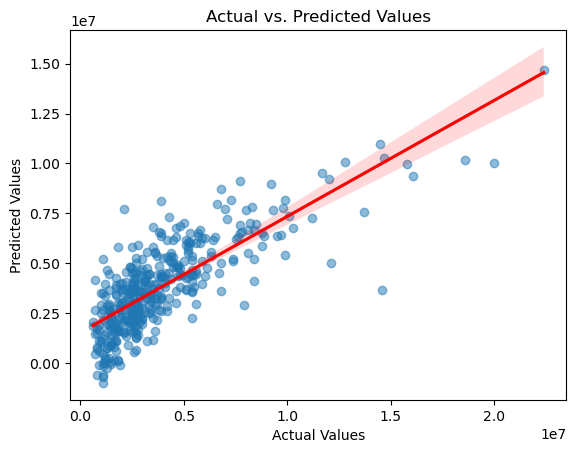

In [36]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ip, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

# Scores Analysis

In [37]:
model_scores.sort_values('cv_mean_r2',ascending=False)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
3,Linear Regression,reduced_power,False,1.504539e+06,1.878372e+06,1.083078e+06,1.298102e+06,0.668567,0.611905,0.613255,0.031444,-2.602495e+12,4.622290e+11,-1.158112e+06,83887.802241,None
4,Linear Regression,reduced_power,True,1.505499e+06,1.874132e+06,1.083317e+06,1.294555e+06,0.668144,0.613655,0.613255,0.031444,-2.602495e+12,4.622290e+11,-1.158112e+06,83887.802241,None
5,Linear Regression,reduced_power_rounded,False,1.504686e+06,1.879025e+06,1.084128e+06,1.301315e+06,0.668391,0.611940,0.613016,0.030873,-2.603602e+12,4.696813e+11,-1.159706e+06,85063.702542,None
9,Linear Regression,imputed_power,False,1.497745e+06,1.870754e+06,1.074859e+06,1.291873e+06,0.671554,0.615047,0.605152,0.031699,-2.649845e+12,4.222436e+11,-1.163806e+06,79869.420382,None
10,Linear Regression,imputed_power,True,1.498421e+06,1.868116e+06,1.073994e+06,1.288004e+06,0.671257,0.616131,0.605152,0.031699,-2.649845e+12,4.222436e+11,-1.163806e+06,79869.420382,None
11,Linear Regression,imputed_power_rounded,False,1.497925e+06,1.871306e+06,1.075700e+06,1.294140e+06,0.671364,0.615121,0.604820,0.031088,-2.651472e+12,4.299040e+11,-1.165545e+06,80884.979118,None
8,Linear Regression,imputed_robust_rounded,False,1.409706e+06,1.855252e+06,9.969621e+05,1.185493e+06,0.708934,0.621697,0.156067,0.940861,-5.346051e+12,5.475232e+12,-1.141570e+06,123494.045397,None
6,Linear Regression,imputed_robust,False,1.410161e+06,1.854111e+06,9.975919e+05,1.184594e+06,0.708844,0.621866,0.154724,0.943830,-5.363971e+12,5.512018e+12,-1.141935e+06,123364.190048,None
7,Linear Regression,imputed_robust,True,1.446557e+06,1.879900e+06,1.010529e+06,1.202775e+06,0.693621,0.611273,0.154724,0.943830,-5.363971e+12,5.512018e+12,-1.141935e+06,123364.190048,None
2,Linear Regression,reduced_robust_rounded,False,1.426599e+06,1.820662e+06,1.012350e+06,1.164967e+06,0.701916,0.635672,-0.100180,1.436621,-6.881649e+12,8.413993e+12,-1.163096e+06,131512.463568,None


# Ensemble Models

## I. Reduced & Robust Scaled Data

##### Importing Data

### C. Random Forest Regression

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rr, y_train)

y_pred = rf_gridsearch.predict(X_test_rr)
print(rf_gridsearch.score(X_test_rr, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6577130635902733
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 10, 'n_estimators': 200, 'n_jobs': -1}


R2 Score: 0.659145068504792, Root Mean Squared Error: 1760343.2280368707, Mean Absolute Error: 1135822.6147197022


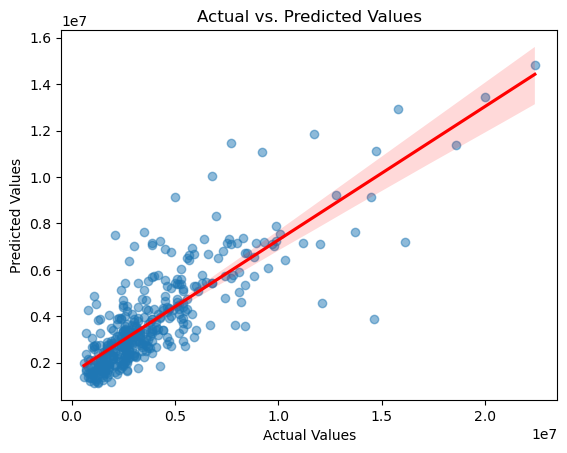

                             feature_importance
uninsured                              0.144409
total_patients                         0.110029
TotalWeeklyHoursOfOperation            0.090806
low_income                             0.068297
hispanic_any_race                      0.064090
total_grant_funding                    0.052887
medicaid                               0.048786
total_sites                            0.046981
diverse_patients_sum                   0.031516
medicare_18_up                         0.023271
lep_patients                           0.021106
private_insurance                      0.019624
migrant_patients                       0.017183
SiteCity_Count                         0.016909
ZipCode_Count                          0.016842


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_4654/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [39]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### D. RandomForestRegressor with PCA

R2 Score: 0.6511522940313192, Root Mean Squared Error: 1780862.94999389, Mean Absolute Error: 1152877.8160139432


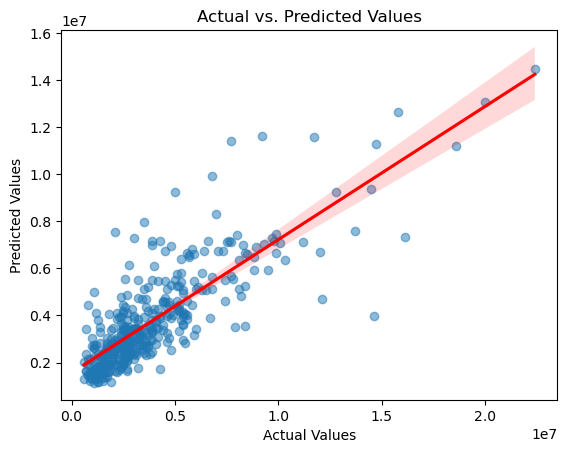

                             feature_importance
uninsured                              0.125196
total_patients                         0.106835
TotalWeeklyHoursOfOperation            0.099413
hispanic_any_race                      0.079097
low_income                             0.054308
total_grant_funding                    0.047094
total_sites                            0.046104
medicaid                               0.045358
diverse_patients_sum                   0.031983
lep_patients                           0.028786
medicare_18_up                         0.020167
ZipCode_Count                          0.019751
PC 3                                   0.017897
homeless_patients                      0.017143
SiteCity_Count                         0.016219


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_4654/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [40]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6571049979924356, Root Mean Squared Error: 1766295.9895427753, Mean Absolute Error: 1134420.6490938077


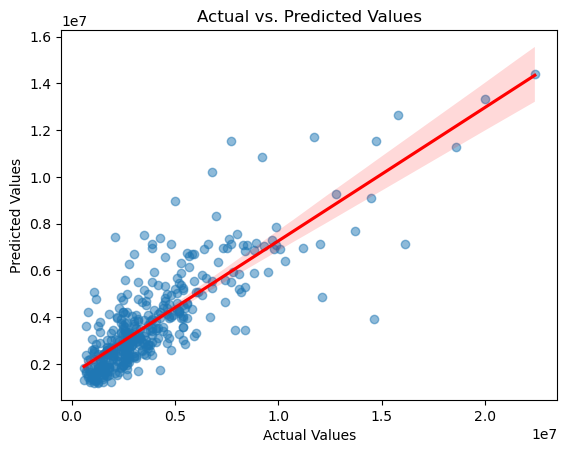

                             feature_importance
uninsured                              0.134786
total_patients                         0.119080
TotalWeeklyHoursOfOperation            0.092302
hispanic_any_race                      0.072747
total_grant_funding                    0.061480
total_sites                            0.055670
low_income                             0.051307
medicaid                               0.040619
lep_patients                           0.033508
diverse_patients_sum                   0.028230
medicare_18_up                         0.018425
SiteCity_Count                         0.016975
ZipCode_Count                          0.016945
homeless_patients                      0.016022
private_insurance                      0.015099


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_4654/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [41]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## II. Reduced & Power Transformed Data

##### Importing Data

### C. Random Forest Regressor with GridSearch

In [42]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rp, y_train)

y_pred = rf_gridsearch.predict(X_test_rp)
print(rf_gridsearch.score(X_test_rp, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6500328125647232
Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 10, 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.6480478724762383, Root Mean Squared Error: 1788769.4145018347, Mean Absolute Error: 1158295.845


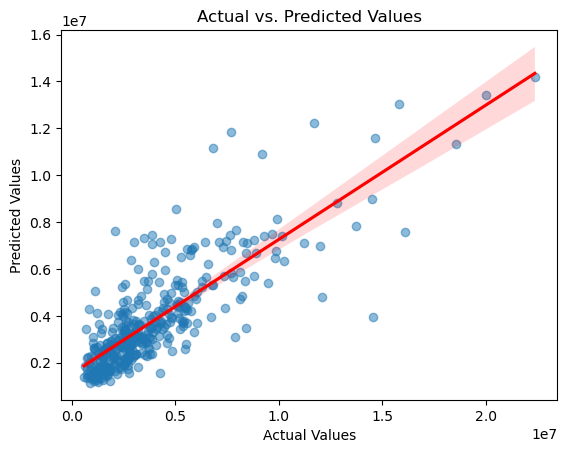

                             feature_importance
total_patients                         0.120734
uninsured                              0.108729
TotalWeeklyHoursOfOperation            0.072004
low_income                             0.059484
hispanic_any_race                      0.051736
total_grant_funding                    0.041147
medicaid                               0.040129
total_sites                            0.037756
diverse_patients_sum                   0.024670
private_insurance                      0.023846
lep_patients                           0.023702
medicare_18_up                         0.020768
ZipCode_Count                          0.018863
homeless_patients                      0.017545
migrant_patients                       0.017147


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_4654/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [43]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### D. RandomForestRegressor with PCA

R2 Score: 0.6595320496512675, Root Mean Squared Error: 1759343.6633557084, Mean Absolute Error: 1146774.5173134329


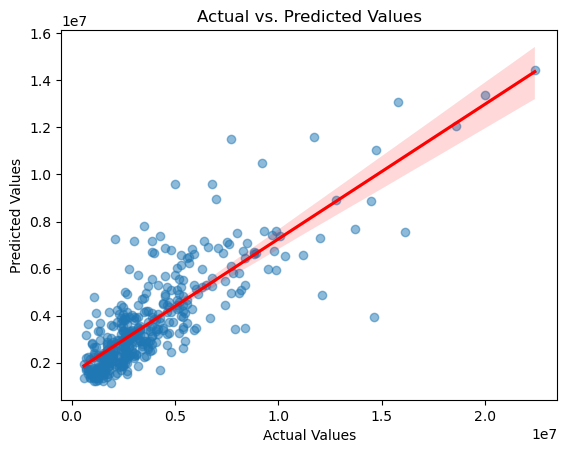

                             feature_importance
PC 1                                   0.106152
uninsured                              0.081084
total_patients                         0.066466
TotalWeeklyHoursOfOperation            0.058051
low_income                             0.048796
medicaid                               0.042337
total_grant_funding                    0.041320
total_sites                            0.036543
hispanic_any_race                      0.035550
diverse_patients_sum                   0.025775
private_insurance                      0.023590
lep_patients                           0.020457
PC 4                                   0.019730
medicare_18_up                         0.019543
ZipCode_Count                          0.017090


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_4654/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [44]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6479793970357846, Root Mean Squared Error: 1789645.2275305532, Mean Absolute Error: 1163844.5273631841


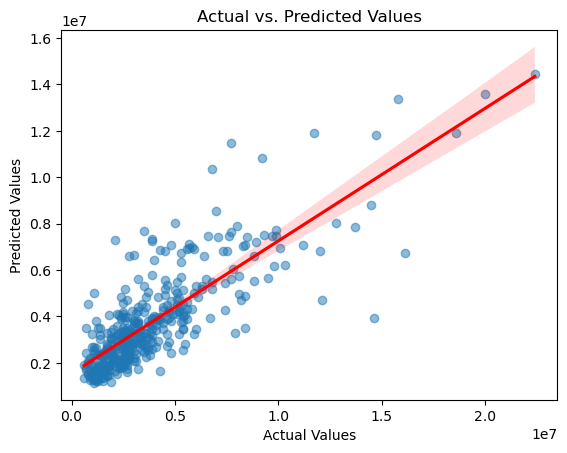

                             feature_importance
uninsured                              0.117313
total_patients                         0.082175
TotalWeeklyHoursOfOperation            0.071901
low_income                             0.071440
hispanic_any_race                      0.053403
medicaid                               0.047349
total_grant_funding                    0.043739
total_sites                            0.030479
medicare_18_up                         0.028091
lep_patients                           0.027583
ZipCode_Count                          0.022658
diverse_patients_sum                   0.021366
SiteCity_Count                         0.018277
homeless_patients                      0.018011
migrant_patients                       0.017155


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_4654/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [45]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power_rounded', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## III. Imputed & Robust Scaled Data

##### Importing Data

### B. Random Forest Regressor

In [46]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_ir, y_train)

y_pred = rf_gridsearch.predict(X_test_ir)
print(rf_gridsearch.score(X_test_ir, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6487302744744614
Best parameters: {'criterion': 'squared_error', 'max_depth': None, 'max_features': 20, 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.6541654854195559, Root Mean Squared Error: 1773155.1184913933, Mean Absolute Error: 1161507.413557214


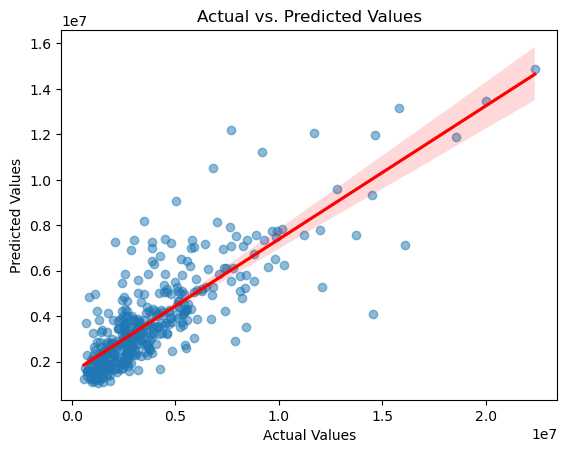

                             feature_importance
uninsured                              0.161176
total_patients                         0.121132
TotalWeeklyHoursOfOperation            0.091242
total_visits                           0.073662
total_cost_care                        0.058639
total_sfs                              0.053794
hispanic_any_race                      0.043402
low_income                             0.034325
total_sites                            0.028185
medicaid                               0.025226
diverse_patients_sum                   0.017231
total_grant_funding                    0.016905
SiteCity_Count                         0.013323
homeless_patients                      0.012829
lep_patients                           0.012756


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_4654/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [47]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6585957749133331, Root Mean Squared Error: 1762452.2159289415, Mean Absolute Error: 1149962.6865671643


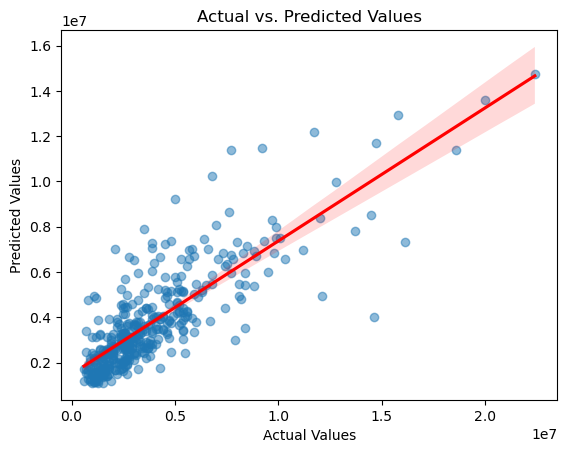

                             feature_importance
uninsured                              0.205736
total_patients                         0.117061
TotalWeeklyHoursOfOperation            0.098129
total_visits                           0.075472
total_cost_care                        0.049113
hispanic_any_race                      0.037254
total_sfs                              0.036466
total_sites                            0.030403
medicaid                               0.027293
total_grant_funding                    0.016080
diverse_patients_sum                   0.014722
low_income                             0.014261
homeless_patients                      0.012901
medicare_18_up                         0.011786
SiteCity_Count                         0.011703


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_4654/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [48]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## IV. Imputed & Power Transformed Data

##### Importing Data

### B. Random Forest Regressor

In [49]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, scoring='r2', cv=kf)

rf_gridsearch.fit(X_train_ip, y_train)

y_pred = rf_gridsearch.predict(X_test_ip)
print(rf_gridsearch.score(X_test_ip, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6538796231411153
Best parameters: {'criterion': 'squared_error', 'max_depth': None, 'max_features': 20, 'n_estimators': 200, 'n_jobs': -1}


R2 Score: 0.4789189094086861, Root Mean Squared Error: 2176532.817246203, Mean Absolute Error: 1286375.2058333333


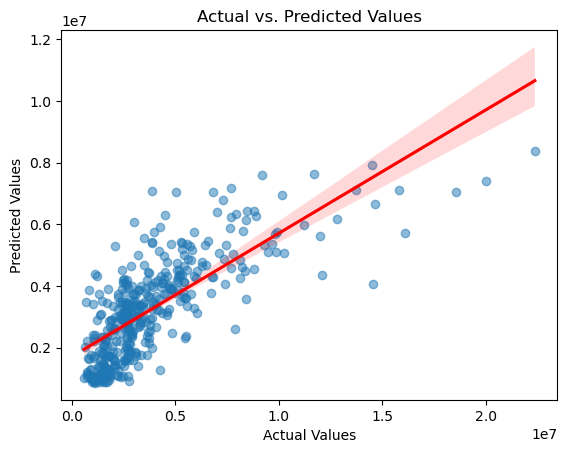

                             feature_importance
uninsured                              0.168285
total_patients                         0.143162
TotalWeeklyHoursOfOperation            0.087954
total_visits                           0.054433
hispanic_any_race                      0.047210
total_sfs                              0.043927
total_cost_care                        0.043850
low_income                             0.038052
total_grant_funding                    0.026587
total_sites                            0.026444
medicaid                               0.020322
lep_patients                           0.016120
SiteCity_Count                         0.014578
diverse_patients_sum                   0.013442
migrant_patients                       0.012451


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_4654/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [50]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.4765417134442105, Root Mean Squared Error: 2182347.6988912015, Mean Absolute Error: 1297888.0597014925


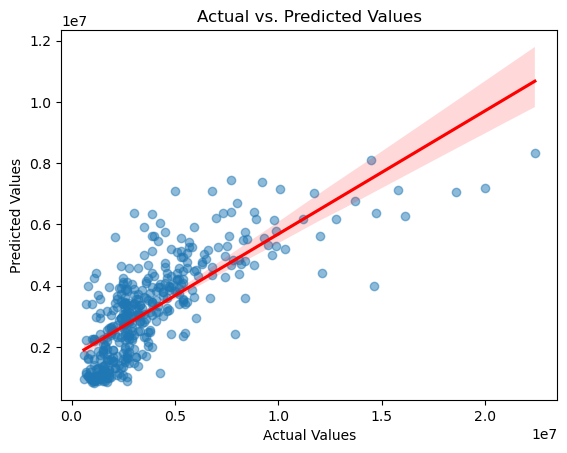

                             feature_importance
uninsured                              0.161783
total_patients                         0.125961
TotalWeeklyHoursOfOperation            0.087986
total_visits                           0.074358
hispanic_any_race                      0.058087
total_sfs                              0.050439
total_cost_care                        0.047640
low_income                             0.028288
total_grant_funding                    0.026103
total_sites                            0.025830
medicaid                               0.019944
diverse_patients_sum                   0.015342
SiteCity_Count                         0.013194
lep_patients                           0.012955
homeless_patients                      0.011091


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_4654/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [51]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

# Scoring Summary

In [52]:
model_scores.sort_values('score_r2_test', ascending=False)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
16,Random Forest Regressor,reduced_power,True,7.690396e+05,1.759344e+06,5.492460e+05,1.146775e+06,0.913406,0.659532,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
12,Random Forest Regressor,reduced_robust,False,7.051991e+05,1.760343e+06,5.180258e+05,1.135823e+06,0.927186,0.659145,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
19,Random Forest Regressor,imputed_robust_rounded,False,5.741328e+05,1.762452e+06,3.866940e+05,1.149963e+06,0.951721,0.658596,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
14,Random Forest Regressor,reduced_robust_rounded,False,6.958064e+05,1.766296e+06,5.195409e+05,1.134421e+06,0.929089,0.657105,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
18,Random Forest Regressor,imputed_robust,False,5.902384e+05,1.773155e+06,3.983909e+05,1.161507e+06,0.948991,0.654165,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
13,Random Forest Regressor,reduced_robust,True,7.063103e+05,1.780863e+06,5.235446e+05,1.152878e+06,0.926957,0.651152,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
15,Random Forest Regressor,reduced_power,False,7.651279e+05,1.788769e+06,5.528516e+05,1.158296e+06,0.914285,0.648048,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
17,Random Forest Regressor,reduced_power_rounded,True,7.585296e+05,1.789645e+06,5.456482e+05,1.163845e+06,0.915729,0.647979,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
1,Linear Regression,reduced_robust,True,1.441341e+06,1.810084e+06,1.019353e+06,1.166834e+06,0.695826,0.639610,-0.101058,1.438584,-6.901222e+12,8.453883e+12,-1.163470e+06,131911.476683,None
0,Linear Regression,reduced_robust,False,1.427076e+06,1.819935e+06,1.012823e+06,1.163950e+06,0.701817,0.635677,-0.101058,1.438584,-6.901222e+12,8.453883e+12,-1.163470e+06,131911.476683,None


In [53]:
best_forest = model_scores[model_scores['model_type'] == 'Random Forest Regressor']\
                .sort_values('score_r2_test', ascending=False).head(2)
best_linreg = model_scores[model_scores['model_type'] == 'Linear Regression']\
                .sort_values('score_r2_test', ascending=False).head(2)

top_models = pd.concat([best_forest, best_linreg], ignore_index=True)
top_models

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Random Forest Regressor,reduced_power,True,7.690396e+05,1.759344e+06,5.492460e+05,1.146775e+06,0.913406,0.659532,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
1,Random Forest Regressor,reduced_robust,False,7.051991e+05,1.760343e+06,5.180258e+05,1.135823e+06,0.927186,0.659145,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
2,Linear Regression,reduced_robust,True,1.441341e+06,1.810084e+06,1.019353e+06,1.166834e+06,0.695826,0.639610,-0.101058,1.438584,-6.901222e+12,8.453883e+12,-1.163470e+06,131911.476683,None
3,Linear Regression,reduced_robust,False,1.427076e+06,1.819935e+06,1.012823e+06,1.163950e+06,0.701817,0.635677,-0.101058,1.438584,-6.901222e+12,8.453883e+12,-1.163470e+06,131911.476683,None


In [69]:
# best_params for the first rf model
best_params_first_model = top_models.loc[0, 'best_params']
print(best_params_first_model)

# best_params for the second rf model
best_params_second_model = top_models.loc[1, 'best_params']
print(best_params_second_model)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# Model Tuning

### **Reduced Power Model with PCA Features**

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}



In [72]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

forest_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [90, 100, 130], 
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 10, 20, 'log2'], 
    'min_samples_split': [2, 3, 5], 
    'min_samples_leaf': [1, 2, 4],  
    'criterion': ['absolute_error', 'friedman_mse', 'squared_error'], 
    'bootstrap': [True],  
    'n_jobs': [-1], 
}

forest_gs = GridSearchCV(forest_model, param_grid=param_grid, cv=kf)

forest_gs.fit(X_train_pca_rp, y_train)

y_pred = forest_gs.predict(X_test_pca_rp)
print(forest_gs.score(X_test_pca_rp, y_test))

best_params = forest_gs.best_params_
print("Best parameters:", best_params)

0.6587402959737183
Best parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 20, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.6621142211476213, Root Mean Squared Error: 1752659.3727011054, Mean Absolute Error: 1139253.093420398


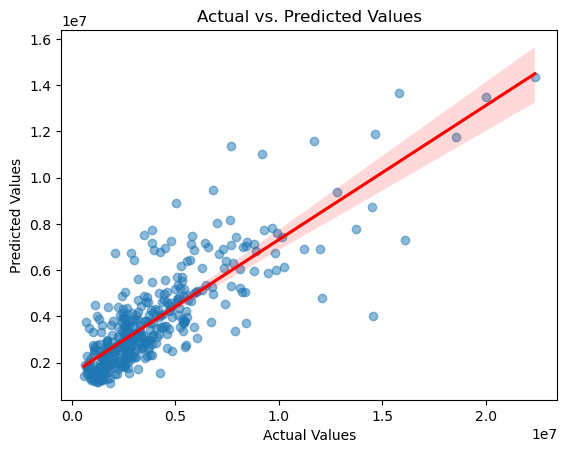

                             feature_importance
PC 1                                   0.152718
total_patients                         0.115656
uninsured                              0.102920
TotalWeeklyHoursOfOperation            0.067786
hispanic_any_race                      0.035166
low_income                             0.030817
total_grant_funding                    0.030002
medicaid                               0.027641
total_sites                            0.019645
PC 4                                   0.018066
SiteCity_Count                         0.015362
private_insurance                      0.014797
medicare_18_up                         0.014212
diverse_patients_sum                   0.014023
medicaid_ratio                         0.013977


In [75]:
rf_model_1 = RandomForestRegressor(**best_params, random_state=33)

rf_model_1.fit(X_train_pca_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model_1, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model_1.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

In [76]:
y_pred_train = rf_model_1.predict(X_train_pca_rp)

In [77]:
residuals = y_test - y_pred

# Create a DataFrame to analyze the residuals
results_df = pd.DataFrame({
    'Actual': y_test.flatten(), 
    'Predicted': y_pred.flatten(),
    'Residuals': residuals.flatten(),
    'Absolute_Residuals': abs(residuals).flatten()
})

# Sort the df by absolute residuals in descending order
results_df = results_df.sort_values(by='Absolute_Residuals', ascending=False)

results_df[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

,Absolute_Residuals
count,402.00
mean,1139253.09
std,1333544.52
min,7117.86
25%,333823.93
50%,734507.27
75%,1392731.36
max,10551145.46


In [78]:
residuals_train = y_train - y_pred_train

# Create a DataFrame to analyze the residuals
results_df_train = pd.DataFrame({
    'Actual': y_train.flatten(), 
    'Predicted': y_pred_train.flatten(),
    'Residuals': residuals_train.flatten(),
    'Absolute_Residuals': abs(residuals_train).flatten()
})

# Sort the df by absolute residuals in descending order
results_df_train = results_df_train.sort_values(by='Absolute_Residuals', ascending=False)

In [79]:
combined_data_test = pd.merge(X_test_rr, results_df, left_index=True, right_index=True, how='inner')

combined_data_train = pd.merge(X_train_rr, results_df_train, left_index=True, right_index=True, how='inner')
combined_data = pd.concat([combined_data_train, combined_data_test], axis=0)

In [80]:
df = pd.read_csv(DATA_PATH +'modeling/data_new_features.csv')
df.shape

(1340, 74)

In [85]:
combined_data = pd.merge(combined_data_test, df[['HealthCenterName', 'HealthCenterState']], left_index=True, right_index=True, how='inner')


In [89]:
combined_data.head(2)

,FundingCHC,FundingMHC,FundingHO,FundingPH,total_other_revenue,hispanic_any_race,total_patients,lep_patients,medicare_18_up,migrant_patients,...,other_revenue_category_1M to 30M,other_revenue_category_Less than 100K,other_revenue_category_Over 30M,other_revenue_category_Zero,Actual,Predicted,Residuals,Absolute_Residuals,HealthCenterName,HealthCenterState
0,0.0,0.0,0.0,0.0,0.172906,0.07084,0.126890,0.833120,-0.075277,-0.208909,...,0.0,0.0,0.0,0.0,2547838,3594789.440,-1046951.440,1046951.440,"HOLYOKE HEALTH CENTER, INC.",MA
1,0.0,0.0,0.0,0.0,-0.268738,-0.05062,1.380709,-0.242674,1.579095,-0.208909,...,0.0,0.0,0.0,1.0,2425436,4877260.235,-2451824.235,2451824.235,MAINE MOBILE HEALTH PROGRAM INC.,ME


In [87]:
combined_data[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

,Absolute_Residuals
count,402.00
mean,1139253.09
std,1333544.52
min,7117.86
25%,333823.93
50%,734507.27
75%,1392731.36
max,10551145.46


In [88]:
combined_data.groupby('HealthCenterState')[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

Absolute_Residuals                                     \
                               count        mean         std        min   
HealthCenterState                                                         
AL                              5.00  2250663.04  2716957.35   10075.89   
CT                             16.00  1539461.00  1898507.03  130087.86   
DC                              8.00   517440.48   489154.06  124330.56   
DE                              3.00   274140.76   169892.26   92619.97   
FL                             26.00   932765.35   970455.42   10875.51   
GA                             10.00   651582.17   845297.72   43750.90   
KY                              7.00   842996.79   677528.60   74159.62   
MA                             37.00  1168224.77  1211859.30   70974.88   
MD                             17.00  1209872.84   958062.79   11690.26   
ME                             18.00  1150947.00  1004606.87   43965.10   
MS                             10.00  1302751.91  1640458.98   83088.46   
NC                              9.00   753749.32   738351.29   65779.08   
NH                              9.00  1472626.58  1204763.36  206045.83   
NJ                             23.00  1062370.52  1412846.11  131653.47   
NY                             63.00  1106589.90  1154095.90   40771.24   
PA                             42.00   947988.06   876577.95    7117.86   
RI                              8.00  1094769.98   720885.40  116607.76   
SC                             10.00  1529254.33  2640338.46   92458.81   
TN                             16.00  1833722.77  2122666.16   92838.59   
VA                             26.00  1005963.25   981107.09  287067.81   
VT                             11.00  2354838.76  2886095.90   32309.12   
WV                             28.00   838449.39   853863.43   43839.68   

                                                                    
                          25%         50%         75%          max  
HealthCenterState                                                   
AL                  212621.68   744040.20  4321976.75   5964600.67  
CT                  374524.73   853547.32  1723875.82   7294754.96  
DC                  183681.74   362157.53   607272.32   1557065.17  
DE                  196546.31   300472.65   364901.15    429329.66  
FL                  240531.12   728597.31   997341.11   3872067.69  
GA                  210489.18   230849.15   775816.14   2781156.19  
KY                  215775.92  1007780.09  1283058.86   1821368.26  
MA                  402775.63   968107.48  1471702.83   6530249.54  
MD                  554680.05   954412.71  1470572.83   3327509.25  
ME                  334930.73   815668.40  1653485.16   3442689.57  
MS                  503311.75   838380.98  1186868.82   5786033.40  
NC                  418669.00   548762.32   703027.72   2613658.67  
NH                  549970.97  1321837.38  2178336.95   3912151.07  
NJ                  378343.80   658743.20  1040716.33   6801302.35  
NY                  327447.08   715484.91  1281290.31   4679019.08  
PA                  324338.81   726069.17  1381278.29   3627319.36  
RI                  624528.14   988987.61  1620203.98   2154639.65  
SC                  197836.02   640475.81  1447280.74   8814568.00  
TN                  754657.29  1050887.73  1923495.62   8028933.55  
VA                  460107.61   687473.49  1047535.56   4052491.18  
VT                 1014504.78  1660560.10  2534017.19  10551145.46  
WV                  325355.65   496094.83  1183009.02   3881449.66

# Results

The model called rf_model_1 performed the best in terms of R2 score. This model was trained and tested with the Reduced Power train/test split that also included PCA features in the dataset. 

Here were the results:
R2 Score: 0.6661138856988604, Root Mean Squared Error: 1742255.0900037773, Mean Absolute Error: 1134002.5798137847


The linear regression models and random forest regressors performed better using the reduced dataset, which columns containing a lot of values were removed instead of imputed.